In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from numpy import linalg as LA

In [ ]:
n = 20
tol = 1e-13
maxIt = 5000
b = np.ones(n)
x0 = np.zeros(n)
x0[0] = 1

l = np.ones(n)
h_tick = (n+1)**2
data = np.array([-h_tick*l, 2*h_tick*l, -h_tick*l])

offsets = np.array([-1, 0, 1])
A = sp.sparse.dia_array((data, offsets), shape=(n, n))
A = A.tocsr()

eigMax = 2*(n+1)**2*(1 - np.cos(n*np.pi/( n+1 ) ) )
eigMin = 2*(n+1)**2*(1 - np.cos(np.pi/( n+1 ) ) )

In [3]:
def fwd_sub(L, b):
    n = L.shape[0]
    x = np.zeros(n)
    for i in range(n):
        tmp = b[i]
        for j in range(i):
            tmp = tmp - L[[i],[j]][0] * x[j]
        x[i] = tmp / L[[i],[i]][0]
    return x

# Q3: Classical iterative methods for symmetric positive definite matrices 
## Part b
### Richardson Function

In [4]:
def Richardson(A,b,w,x0,tol,maxIt):
    n = b.size
    x = np.zeros((maxIt, n))
    x[0,:] = x0
    r = b - A @ x[0,:]
    i = 1
    while LA.norm(r)>tol and i<maxIt:
        x[i,:] = x[i-1,:]+w*r
        r = b - A @ x[i,:]
        i +=1
    return x,i

w = 1/eigMax
xRich,iRich = Richardson(A,b,w,x0,tol,maxIt)

print('The l2 norm of the residual after', iRich,'Richardson iterations is',LA.norm(b-A@xRich[iRich-1,:]))

The l2 norm of the residual after 5000 Richardson iterations is 2.1755578216530395e-12


### Optimal Richardson Function
This is exactly the same as above, but we choose omega optimally

In [5]:
wOpt = 2/(eigMax+eigMin)
xOptRich,iOptRich = Richardson(A,b,wOpt,x0,tol,maxIt)
print('The l2 norm of the residual after', iOptRich,'Optimal Richardson iterations is',LA.norm(b-A@xOptRich[iOptRich-1,:]))

The l2 norm of the residual after 5000 Optimal Richardson iterations is 6.20386109427097e-13


## Jacobi Function

In [6]:
def Jacobi(A, b, x0, tol, maxIt):
    n = b.size
    d = A.diagonal()
    D = sp.sparse.dia_array((d, np.array([0])), shape=(n,n))
    N = A - D
    DInv = sp.sparse.dia_array((np.reciprocal(d), np.array([0])), shape=(n,n))
    x = np.zeros((maxIt, n))
    x[0,:] = x0
    r = b - A @ x[0,:]
    i = 1
    while LA.norm(r)>tol and i<maxIt:
        x[i,:] = DInv @ (b - N @ x[i-1,:])
        r = b - A @ x[i,:]
        i +=1
    return x,i

xJac, iJac = Jacobi(A, b, x0, tol, maxIt)
print('The l2 norm of the residual after', iJac ,'Jacobi iterations is',LA.norm(b-A@xJac[iJac-1,:]))

The l2 norm of the residual after 2923 Jacobi iterations is 9.216536349095496e-14


### Gauss-Seidel Function

In [7]:
def GS(A, b, x0, x1, tol, maxIt):
    n = b.size
        
    M = sp.sparse.tril(A).tocsr()
    N = A - M
    N = N.tocsr()
       
    x = np.zeros((maxIt, n))
    x[0,:] = x0
    r = b - A @ x[0,:]
    i = 1
    while LA.norm(r)>tol and i<maxIt:
        
        x[i,:] = fwd_sub(M, (b-N @ x[i-1,:]))
        r = b - A @ x[i,:]
        i +=1
        
    return x,i

xGS, iGS = GS(A, b, x0, x0, tol, maxIt)
print('The l2 norm of the residual after', iGS ,'Gauss-Seidel iterations is',LA.norm(b-A@xGS[iGS-1,:]))

The l2 norm of the residual after 1399 Gauss-Seidel iterations is 9.928547664004924e-14


### S.O.R. Function

In [8]:
def SOR(A, b, x0, x1, theta, tol, maxIt):
    n = b.size
        
    M = sp.sparse.tril(A).tocsr()
    N = A - M
    N = N.tocsr()
       
    x = np.zeros((maxIt, n))
    x[0,:] = x0
    r = b - A @ x[0,:]
    i = 1

    while LA.norm(r)>tol and i<maxIt:       
        x[i,:] = (1-theta) * x[i-1] + theta * fwd_sub(M, (b-N @ x[i-1,:]) )
        r = b - A @ x[i,:]
        normR = LA.norm(r)
        i +=1
        
    return x,i

theta = 1.2
xSOR, iSOR = SOR(A, b, x0, x0, theta, tol, maxIt)
print('The l2 norm of the residual after', iSOR ,'S.O.R. iterations is',LA.norm(b-A@xSOR[iSOR-1,:]))

The l2 norm of the residual after 1169 S.O.R. iterations is 9.885549501104071e-14


### Optimal S.O.R. Function

The Optimal S.O.R. function is identical in principal, but the forward substitution is very slow compared to spsolve. For doing this iteratively to find the optimal theta, I have chosen to use spsolve to speed up the process and called that function quickSOR

In [9]:
def quickSOR(A, b, x0, x1, theta, tol, maxIt):
    n = b.size
        
    M = sp.sparse.tril(A).tocsr()
    N = A - M
    N = N.tocsr()
       
    x = np.zeros((maxIt, n))
    x[0,:] = x0
    r = b - A @ x[0,:]
    i = 1

    while LA.norm(r)>tol and i<maxIt:       
        x[i,:] = (1-theta) * x[i-1] + theta * sp.sparse.linalg.spsolve(M, (b-N @ x[i-1,:]) )
        r = b - A @ x[i,:]
        normR = LA.norm(r)
        i +=1
        
    return normR, i

This iterates over thetas to find the fastest convergence and reports it

In [10]:
stepSize = 0.05
thetas = np.arange(0,2,stepSize)
resultsSOR = np.zeros((len(thetas),2))

for j in range(len(thetas)):
    resultsSOR[j,:] = quickSOR(A, b, x0, x0, thetas[j], tol, maxIt)

optTheta = thetas[np.argmin(resultsSOR[:,1])]

print('The theta which converges fastest is ', optTheta, ' in ', min(resultsSOR[:,1]), ' steps' )


The theta which converges fastest is  1.55  in  906.0  steps


Now I'll run the S.O.R. function using the found optimal theta in the original function to get the x values and to doublecheck the number of steps to converge.

In [11]:
xOptSOR, iOptSOR = SOR(A, b, x0, x0, optTheta, tol, maxIt)
print('The l2 norm of the residual after', iOptSOR ,'Optimal S.O.R. iterations is',LA.norm(b-A@xOptSOR[iOptSOR-1,:]))

The l2 norm of the residual after 906 Optimal S.O.R. iterations is 9.947598300641403e-14


### Running the code

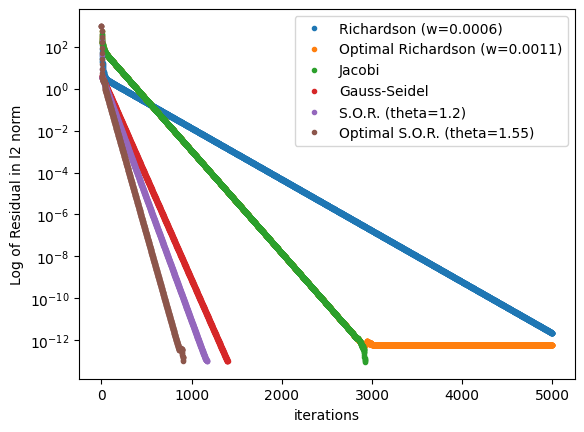

In [25]:
resNormRich = np.zeros(iRich)
for j in range(0,iRich):
    resNormRich[j] = LA.norm(b-A@xRich[j,:])
resNormOptRich = np.zeros(iOptRich)
for j in range(0,iOptRich):
    resNormOptRich[j] = LA.norm(b-A@xOptRich[j,:])
resNormJac = np.zeros(iJac)
for j in range(0,iJac):
    resNormJac[j] = LA.norm(b-A@xJac[j,:])
resNormGS = np.zeros(iGS)
for j in range(0,iGS):
    resNormGS[j] = LA.norm(b-A@xGS[j,:])
resNormSOR = np.zeros(iSOR)
for j in range(0,iSOR):
    resNormSOR[j] = LA.norm(b-A@xSOR[j,:])
resNormOptSOR = np.zeros(iOptSOR)
for j in range(0,iOptSOR):
    resNormOptSOR[j] = LA.norm(b-A@xOptSOR[j,:])

plt.xlabel("iterations")
plt.ylabel("Log of Residual in l2 norm")
plt.plot( np.linspace(0,iRich-1,iRich), resNormRich, '.', label=f"Richardson (w={w:,.4f})")
plt.plot( np.linspace(0,iOptRich-1,iOptRich), resNormOptRich, '.', label=f"Optimal Richardson (w={wOpt:,.4f})")
plt.plot( np.linspace(0,iJac-1,iJac), resNormJac, '.', label=f"Jacobi")
plt.plot( np.linspace(0,iGS-1,iGS), resNormGS, '.', label=f"Gauss-Seidel")
plt.plot( np.linspace(0,iSOR-1,iSOR), resNormSOR, '.', label=f"S.O.R. (theta={theta})")
plt.plot( np.linspace(0,iOptSOR-1,iOptSOR), resNormOptSOR, '.', label=f"Optimal S.O.R. (theta={optTheta:,.2f})")
plt.yscale("log")
plt.legend(loc="upper right")
plt.show()

# Q4: Steepest Descent and Conjugate Gradient
## Part b
### Steepest Descent

In [13]:
def SD(A, b, x0, tol, maxIt):
    n = b.size
    x = np.zeros((maxIt, n))
    x[0,:] = x0
    r = b - A @ x[0,:]
    i = 0
    while LA.norm(r)>tol and i<maxIt-1:
        lam = (r.T @ r) / (r.T @ A @ r)
        x[i+1,:] = x[i,:] + lam * r
        r = b - A @ x[i+1,:]
        i +=1
    return x,i+1

### Conjugate Gradient

In [20]:
def CG(A, b, x0, tol, maxIt):
    n = b.size
    x = np.zeros((maxIt, n))
    x[0,:] = x0
    r = b - A @ x[0,:]
    s = r
    i = 0
    while LA.norm(r)>tol and i<maxIt-1:
        lam = (r.T @ s) / (s.T @ A @ s)
        x[i+1,:] = x[i,:] + lam * s
        rp = r - lam * A @ s
        s = rp + (rp.T @ rp) / (r.T @ r) * s
        r = rp
        i +=1
    return x,i+1

In [21]:
xSD, iSD = SD(A, b, x0, tol, maxIt)
print('The l2 norm of the residual after', iSD ,'Steepest Descent iterations is',LA.norm(b-A@xSD[iSD-1,:]))
xCG, iCG = CG(A, b, x0, tol, maxIt)
print('The l2 norm of the residual after', iCG ,'Conjugate Gradient iterations is',LA.norm(b-A@xCG[iCG-1,:]))

The l2 norm of the residual after 2793 Steepest Descent iterations is 9.949184207116308e-14
The l2 norm of the residual after 22 Conjugate Gradient iterations is 1.768523598095391e-13


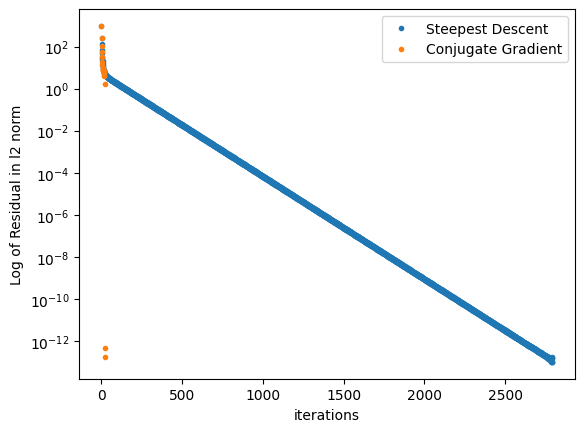

In [22]:
resNormSD = np.zeros(iSD)
for j in range(0,iSD):
    resNormSD[j] = LA.norm(b-A@xSD[j,:])
resNormCG = np.zeros(iCG)
for j in range(0,iCG):
    resNormCG[j] = LA.norm(b-A@xCG[j,:])

plt.xlabel("iterations")
plt.ylabel("Log of Residual in l2 norm")
plt.plot( np.linspace(0,iSD-1,iSD), resNormSD, '.', label=f"Steepest Descent")
plt.plot( np.linspace(0,iCG-1,iCG), resNormCG, '.', label=f"Conjugate Gradient")
plt.yscale("log")
plt.legend(loc="upper right")
plt.show()

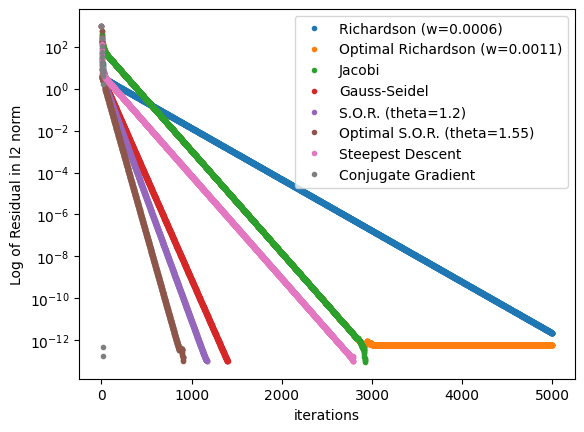

In [24]:
plt.xlabel("iterations")
plt.ylabel("Log of Residual in l2 norm")
plt.plot( np.linspace(0,iRich-1,iRich), resNormRich, '.', label=f"Richardson (w={w:,.4f})")
plt.plot( np.linspace(0,iOptRich-1,iOptRich), resNormOptRich, '.', label=f"Optimal Richardson (w={wOpt:,.4f})")
plt.plot( np.linspace(0,iJac-1,iJac), resNormJac, '.', label=f"Jacobi")
plt.plot( np.linspace(0,iGS-1,iGS), resNormGS, '.', label=f"Gauss-Seidel")
plt.plot( np.linspace(0,iSOR-1,iSOR), resNormSOR, '.', label=f"S.O.R. (theta={theta})")
plt.plot( np.linspace(0,iOptSOR-1,iOptSOR), resNormOptSOR, '.', label=f"Optimal S.O.R. (theta={optTheta:,.2f})")
plt.plot( np.linspace(0,iSD-1,iSD), resNormSD, '.', label=f"Steepest Descent")
plt.plot( np.linspace(0,iCG-1,iCG), resNormCG, '.', label=f"Conjugate Gradient")
plt.yscale("log")
plt.legend(loc="upper right")
plt.show()